In [13]:
import numpy as np
from arch import arch_model
import numpy as np
from scipy import optimize
from scipy.stats import norm
from scipy import special
import pandas as pd
import matplotlib.pyplot as plt

In [4]:
import matplotlib.pyplot as plt

## Read in data

In [11]:
import pandas as pd

In [12]:
daily_sp500_returns = pd.read_fwf("daily_sp500_ret.txt").to_numpy()[4:]
monthly_sp500_returns = pd.read_fwf("monthly_sp500_ret.txt").to_numpy()[4:]

In [13]:
sp500_monthly_garch_model_11 = arch_model(monthly_sp500_returns[:,1], vol='Garch', p=1, o=0, q=1)
sp500_monthly_garch_fitted = monthly_garch_model_11.fit()

NameError: name 'monthly_garch_model_11' is not defined

In [ ]:
sp500_monthly_garch_fitted.params

# Problem 4

In [48]:
def simulate_euler_CIR(kappa, theta, sigma2, nsteps):
    dt = 1/250.0
    rates = np.zeros(nsteps)
    rates[0] = theta
    noise = np.random.normal(0, np.sqrt(dt), size=nsteps)
    for t in range(1, nsteps):
        rates[t] = abs(rates[t-1] + kappa*(theta - rates[t-1])*dt + np.sqrt(sigma2*rates[t-1])*noise[t])
    return rates

In [49]:
rates = simulate_euler_CIR(kappa=0.234, theta=0.081, sigma2=0.0073, nsteps=100000)

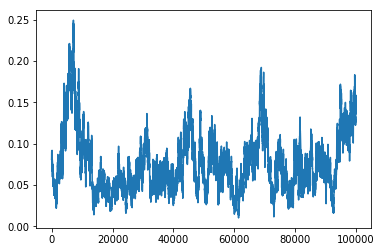

In [50]:
plt.plot(rates)

In [51]:
monthly_rates = rates[::250]
monthly_rates.shape

(400,)

$$\epsilon_{k+1} - E{\epsilon_{k+1}|F_k} = 0$$
$$r_{k+1} - r_k - \kappa(\theta - r_t) \delta_k = 0$$

In [52]:

# define moment functions

def g1(pv, data, dt=1):
    theta, kappa, sig2 = pv
    return data[1:] - data[:-1] - kappa*(theta - data[:-1])*dt

def g2(pv, data, dt=1):
    theta, kappa, sig2 = pv
    return data[:-1]*g1(pv, data)

def g3(pv, data, dt=1):
    theta, kappa, sig2 = pv
    return (g1(pv, data))**2 - sig2*data[:-1]*dt

def g4(pv, data, dt=1):
    theta, kappa, sig2 = pv
    return data[:-1] * g3(pv, data) - sig2*(data[:-1]**2)*dt

In [53]:
def GMM(moments, param_vect, data, n_iter=1):
    results = []
    W = np.eye(len(moments))
    
    def G(W):
        def inner(pv):
            moment_means = np.mean(np.array([g(pv, data) for g in moments]), axis=1)
            retval = moment_means @ W @ moment_means
            return retval
        return inner
    
    res = optimize.minimize(G(W), x0 = param_vect, method = 'BFGS', tol = 1.e-9)
    
    res = res.x
    results.append(res.copy())
    for _ in range(n_iter):
        
        S = np.zeros_like(W)
        for t in range(data.shape[0]-1):
            moments_t = np.array([g(res, data[t:t+2]) for g in moments])
            
            S += np.outer(moments_t, moments_t)
        S /= (data.shape[0]-1)
        moment_means = np.array([np.mean(g(res, data)) for g in moments])
        S -= np.outer(moment_means, moment_means)
        W = np.linalg.inv(S)
        res = optimize.minimize(G(W), x0 = param_vect, method = 'BFGS', tol = 1.e-9)
        res=res.x
        results.append(res.copy())
    return results

In [54]:
theta_init = 0.1 #np.mean(monthly_rates)
kappa_init = 0.1 #0.234
sig2_init = 0.1 #0.0073
opt_input = [theta_init, kappa_init, sig2_init]

In [55]:
results = GMM([g1, g2, g3, g4], opt_input, monthly_rates, n_iter=10)

In [56]:
results

[array([0.07594762, 0.17146573, 0.00528497]),
 array([0.06916681, 0.16241516, 0.0021611 ]),
 array([0.06516997, 0.16594689, 0.00088804]),
 array([0.06316851, 0.16784781, 0.00094283]),
 array([0.06221908, 0.16827138, 0.00092642]),
 array([0.0617811 , 0.1683883 , 0.00092879]),
 array([0.06158211, 0.16843955, 0.00092811]),
 array([0.06149182, 0.16846083, 0.00092816]),
 array([0.06145097, 0.16847061, 0.00092812]),
 array([0.06143248, 0.16847498, 0.00092811]),
 array([0.06142411, 0.16847696, 0.0009281 ])]

In [23]:
def QML_G(data):
    def qml(pv):
        theta, kappa, sig2 = pv
        lik = 0
        for i in range(data.shape[0]-1):
            lik += norm.logpdf(data[i + 1], data[i] + kappa*(theta - data[i]), 
                        np.sqrt(abs(sig2) * data[i]))
        return -lik
    return qml

In [24]:
optimize.minimize(QML_G(monthly_rates), x0 = [0.1, 0.1, 0.1])  # looks good: hess_inv is our covariance matrix

      fun: -987.5728118258288
 hess_inv: array([[1.23066088e-04, 1.01448862e-04, 4.39806127e-06],
       [1.01448862e-04, 8.36577886e-05, 3.57834113e-06],
       [4.39806127e-06, 3.57834113e-06, 3.45904515e-07]])
      jac: array([0.00049591, 0.00010681, 0.0034256 ])
  message: 'Desired error not necessarily achieved due to precision loss.'
     nfev: 141
      nit: 12
     njev: 28
   status: 2
  success: False
        x: array([0.07934701, 0.20199167, 0.00571348])

In [25]:
yts = 2 * np.sqrt(monthly_rates)

In [26]:
def SO_lik(yts):
    def like(pv):
        theta, kappa, sig2 = pv
        A = (2/yts[:-1])*(kappa*theta - (sig2)/4) - kappa*(yts[:-1])/2 
        B = (-2/(yts[:-1]**2)) * (kappa*theta - (sig2)/4) - kappa/2
        C = (4/(yts[:-1]**3)) * (kappa*theta - (sig2)/4)

        K = np.exp(B) - 1

        M = yts[:-1] + (A/B)*K + ((sig2) * C)/(2 * (B**2))*(K - B)
        V = (sig2)/(2*B) * (np.exp(2*B) - 1)

        lik = 0
        for i in range(yts.shape[0] -1):
            lik -= -((yts[i + 1] - M[i])**2) / (2*V[i]) - (1/2)*np.log(2*np.pi*V[i])
        return lik
    return like

In [27]:
optimize.minimize(SO_lik(yts), x0 = [0.1, 0.1, 0.1],
                  bounds = [(0.0, 1), (0.0, 1), (1e-15, 1)], tol = 1.e-14)

      fun: -471.3670331844773
 hess_inv: <3x3 LbfgsInvHessProduct with dtype=float64>
      jac: array([-3.24007488e-04, -3.97903932e-05,  4.84305929e-03])
  message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 148
      nit: 21
   status: 0
  success: True
        x: array([0.07922579, 0.24011389, 0.00701166])

In [40]:
SO_lik(yts)([0.05, 0.1, 0.05**2])

-318.5878083933145

In [41]:
SO_lik(yts)([0.08311736, 0.23470817, 0.00717133])

-465.98197007223746

In [33]:
#4. Exact Likelihood
def exact_lik(yts):
    def e_like(pv):
        theta = pv[0]
        kappa = pv[1]
        sig = pv[2]
        lik = 0
    
        c = (2 * kappa) / ((sig**2) * (1 - np.exp(-kappa)) )
        u = c * monthly_rates * np.exp(-kappa)
        v = c * monthly_rates
        q = (2 * kappa * theta) / (sig**2) - 1
     
        for i in range(yts.shape[0] -1):
            lik += np.log(c * np.exp(-(u[i] + v[i + 1])) * (v[i + 1] / u[i])**(q / 2) 
                    * special.iv(q, 2*np.sqrt(u[i] * v[i + 1])))
        return -lik
    return e_like



In [34]:
optimize.minimize(exact_lik(yts), x0 = [0.1, 0.1, 0.1],
                 tol = 1.e-14)

      fun: -994.8018226968708
 hess_inv: array([[ 2.06853969e-05, -6.76733263e-06,  2.05227423e-06],
       [-6.76733263e-06,  4.33177585e-04,  2.62672967e-05],
       [ 2.05227423e-06,  2.62672967e-05,  1.00597570e-05]])
      jac: array([ 5.34057617e-05,  2.28881836e-05, -9.91821289e-05])
  message: 'Desired error not necessarily achieved due to precision loss.'
     nfev: 81
      nit: 9
     njev: 16
   status: 2
  success: False
        x: array([0.07936261, 0.24207133, 0.08387675])